In [1]:
# Установка необходимых библиотек
!pip install torch torchvision diffusers transformers accelerate matplotlib Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import torch
import torch.nn as nn
from diffusers import StableDiffusionPipeline, DDIMScheduler
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
from torch.quantization import quantize_dynamic
import gc

2025-12-25 02:29:15.622826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766629755.807359      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766629755.864843      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# Очистка памяти GPU
torch.cuda.empty_cache()
gc.collect()

240

In [4]:
# 1. Загрузка исходной модели
print("Загрузка исходной модели...")
model_id = "runwayml/stable-diffusion-v1-5"

Загрузка исходной модели...


In [5]:
# Загрузка с float32
pipe_fp32 = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    safety_checker=None
)
pipe_fp32 = pipe_fp32.to("cuda" if torch.cuda.is_available() else "cpu")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
# 2. Создание квантизированной версии
print("\nСоздание квантизированной версии...")
pipe_fp16 = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None
)
pipe_fp16 = pipe_fp16.to("cuda" if torch.cuda.is_available() else "cpu")


Создание квантизированной версии...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [7]:
# 3. Функция для генерации изображений
def generate_image(pipe, prompt, seed=42, steps=20):
    generator = torch.Generator(device=pipe.device).manual_seed(seed)
    
    start_time = time.time()
    
    with torch.autocast("cuda") if torch.cuda.is_available() else nullcontext():
        image = pipe(
            prompt,
            num_inference_steps=steps,
            generator=generator,
            guidance_scale=7.5
        ).images[0]
    
    gen_time = time.time() - start_time
    return image, gen_time

In [8]:
# 4. Сравнительный анализ
prompts = [
    "A beautiful sunset over mountains",
    "A cyberpunk city street at night",
    "A cute cat sitting on a windowsill",
    "An astronaut riding a horse on Mars"
]

results = {
    'fp32': {'images': [], 'times': [], 'memory': []},
    'fp16': {'images': [], 'times': [], 'memory': []}
}

In [9]:
print("\nГенерация изображений для сравнения...")
for i, prompt in enumerate(prompts):
    print(f"\nПромпт {i+1}: {prompt}")
    
    # FP32
    torch.cuda.reset_peak_memory_stats()
    img_fp32, time_fp32 = generate_image(pipe_fp32, prompt)
    memory_fp32 = torch.cuda.max_memory_allocated() / 1024**2
    
    results['fp32']['images'].append(img_fp32)
    results['fp32']['times'].append(time_fp32)
    results['fp32']['memory'].append(memory_fp32)
    
    # FP16
    torch.cuda.reset_peak_memory_stats()
    img_fp16, time_fp16 = generate_image(pipe_fp16, prompt)
    memory_fp16 = torch.cuda.max_memory_allocated() / 1024**2
    
    results['fp16']['images'].append(img_fp16)
    results['fp16']['times'].append(time_fp16)
    results['fp16']['memory'].append(memory_fp16)
    
    print(f"  FP32: {time_fp32:.2f} сек, {memory_fp32:.1f} MB")
    print(f"  FP16: {time_fp16:.2f} сек, {memory_fp16:.1f} MB")


Генерация изображений для сравнения...

Промпт 1: A beautiful sunset over mountains


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  FP32: 6.65 сек, 9239.2 MB
  FP16: 6.08 сек, 7304.7 MB

Промпт 2: A cyberpunk city street at night


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  FP32: 6.06 сек, 9232.9 MB
  FP16: 6.07 сек, 7304.7 MB

Промпт 3: A cute cat sitting on a windowsill


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  FP32: 6.06 сек, 9232.9 MB
  FP16: 6.07 сек, 7304.7 MB

Промпт 4: An astronaut riding a horse on Mars


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  FP32: 6.06 сек, 9232.9 MB
  FP16: 6.07 сек, 7304.7 MB



Визуализация результатов...


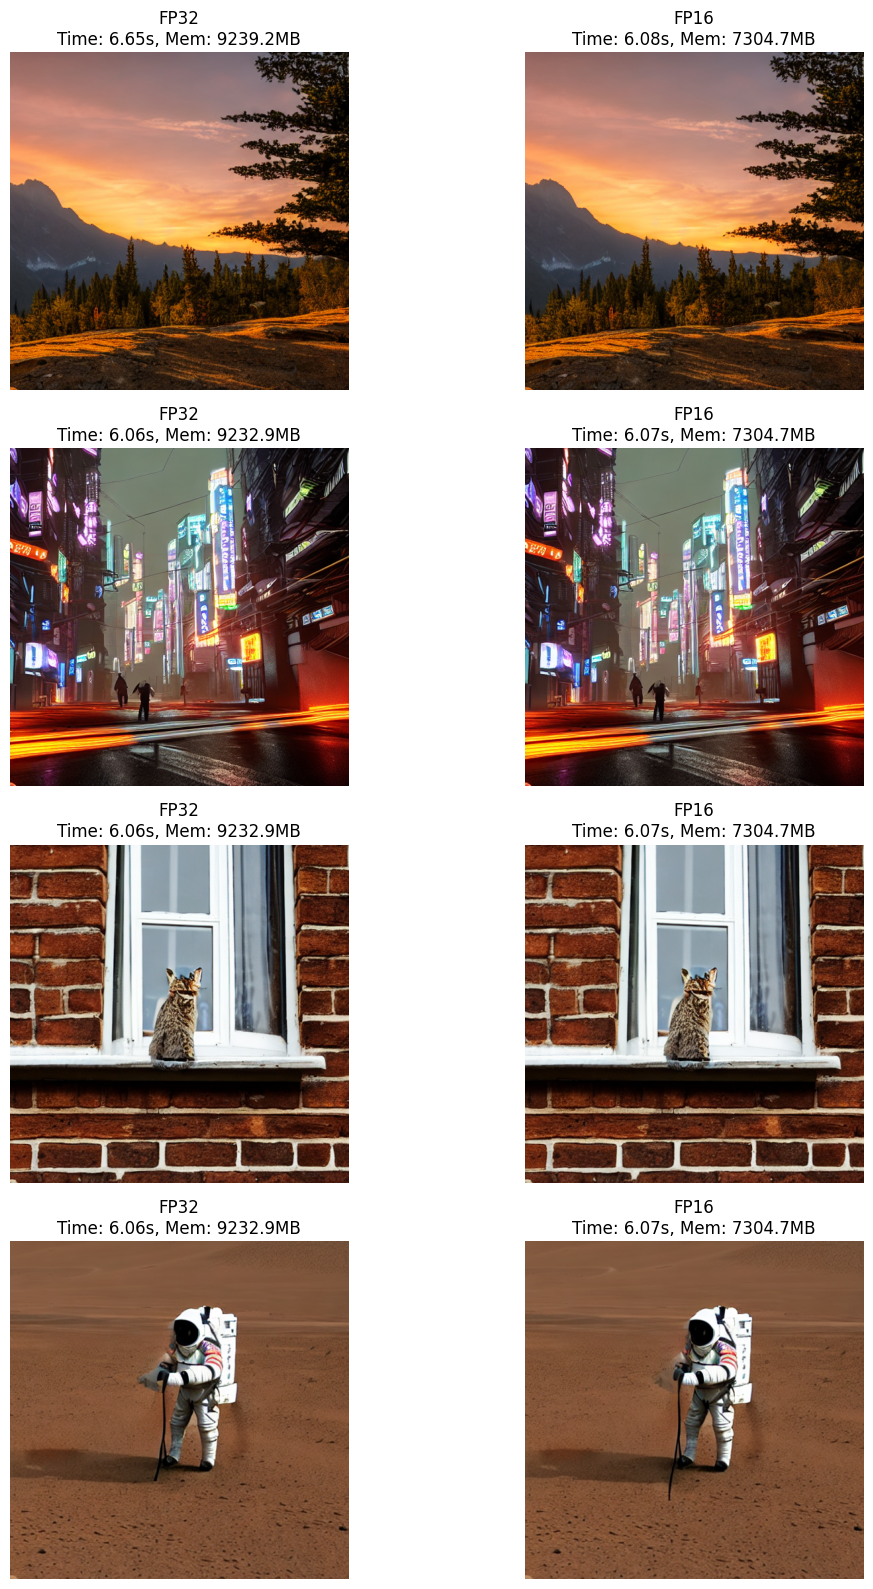

In [10]:
# 5. Визуализация результатов
print("\nВизуализация результатов...")
fig, axes = plt.subplots(len(prompts), 2, figsize=(12, 4*len(prompts)))

for i in range(len(prompts)):
    axes[i, 0].imshow(results['fp32']['images'][i])
    axes[i, 0].set_title(f"FP32\nTime: {results['fp32']['times'][i]:.2f}s, Mem: {results['fp32']['memory'][i]:.1f}MB")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(results['fp16']['images'][i])
    axes[i, 1].set_title(f"FP16\nTime: {results['fp16']['times'][i]:.2f}s, Mem: {results['fp16']['memory'][i]:.1f}MB")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
# 6. Сравнение метрик
print("\n" + "="*50)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
print("="*50)

# Средние значения
avg_time_fp32 = np.mean(results['fp32']['times'])
avg_time_fp16 = np.mean(results['fp16']['times'])
avg_mem_fp32 = np.mean(results['fp32']['memory'])
avg_mem_fp16 = np.mean(results['fp16']['memory'])

print(f"\nСреднее время генерации:")
print(f"  FP32: {avg_time_fp32:.2f} сек")
print(f"  FP16: {avg_time_fp16:.2f} сек")
print(f"  Ускорение: {avg_time_fp32/avg_time_fp16:.2f}x")

print(f"\nСреднее использование памяти:")
print(f"  FP32: {avg_mem_fp32:.1f} MB")
print(f"  FP16: {avg_mem_fp16:.1f} MB")
print(f"  Экономия памяти: {avg_mem_fp32/avg_mem_fp16:.2f}x")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ

Среднее время генерации:
  FP32: 6.21 сек
  FP16: 6.07 сек
  Ускорение: 1.02x

Среднее использование памяти:
  FP32: 9234.5 MB
  FP16: 7304.7 MB
  Экономия памяти: 1.26x


In [12]:
# 7. Расчет PSNR для сравнения качества
def calculate_psnr(img1, img2):
    """Вычисление PSNR между двумя изображениями"""
    img1_np = np.array(img1).astype(np.float32)
    img2_np = np.array(img2).astype(np.float32)
    
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

print("\n\nОценка качества (PSNR):")
print("-" * 30)
for i in range(len(prompts)):
    psnr = calculate_psnr(results['fp32']['images'][i], results['fp16']['images'][i])
    print(f"Изображение {i+1}: PSNR = {psnr:.2f} dB")



Оценка качества (PSNR):
------------------------------
Изображение 1: PSNR = 50.44 dB
Изображение 2: PSNR = 41.70 dB
Изображение 3: PSNR = 36.79 dB
Изображение 4: PSNR = 35.97 dB


In [13]:
# 8. Дополнительный анализ с разным количеством шагов
print("\n" + "="*50)
print("АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА ШАГОВ")
print("="*50)

steps_to_test = [10, 20, 30, 50]
prompt_test = "A beautiful landscape with mountains and lake"

step_results = {'fp32': [], 'fp16': []}

for steps in steps_to_test:
    print(f"\nШагов: {steps}")
    
    # FP32
    img_fp32, time_fp32 = generate_image(pipe_fp32, prompt_test, steps=steps)
    step_results['fp32'].append((steps, time_fp32, img_fp32))
    
    # FP16
    img_fp16, time_fp16 = generate_image(pipe_fp16, prompt_test, steps=steps)
    step_results['fp16'].append((steps, time_fp16, img_fp16))
    
    print(f"  FP32: {time_fp32:.2f} сек")
    print(f"  FP16: {time_fp16:.2f} сек")


АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА ШАГОВ

Шагов: 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  FP32: 3.31 сек
  FP16: 3.32 сек

Шагов: 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  FP32: 6.06 сек
  FP16: 6.07 сек

Шагов: 30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  FP32: 8.81 сек
  FP16: 8.83 сек

Шагов: 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  FP32: 14.31 сек
  FP16: 14.34 сек


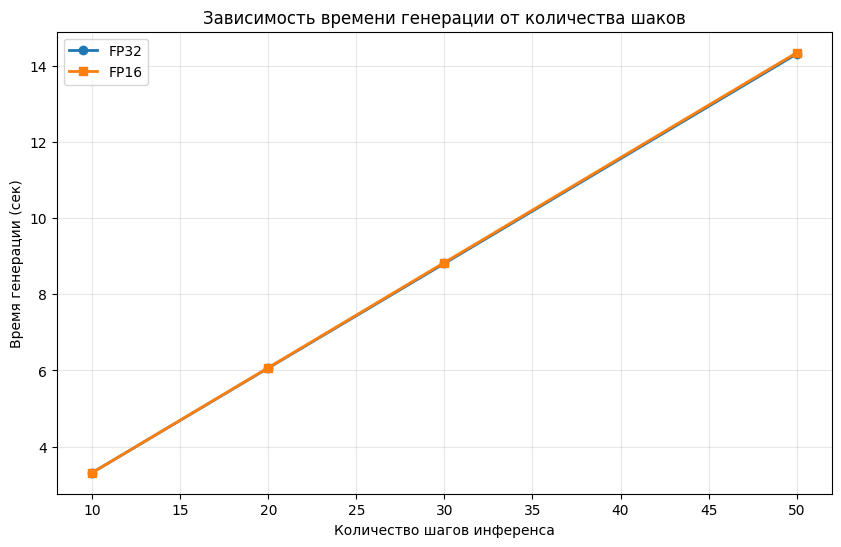

In [14]:
# 9. Визуализация зависимости времени от количества шагов
steps = [s[0] for s in step_results['fp32']]
times_fp32 = [s[1] for s in step_results['fp32']]
times_fp16 = [s[1] for s in step_results['fp16']]

plt.figure(figsize=(10, 6))
plt.plot(steps, times_fp32, 'o-', label='FP32', linewidth=2)
plt.plot(steps, times_fp16, 's-', label='FP16', linewidth=2)
plt.xlabel('Количество шагов инференса')
plt.ylabel('Время генерации (сек)')
plt.title('Зависимость времени генерации от количества шаков')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# 10. Анализ потребления памяти по компонентам
print("\n" + "="*50)
print("АНАЛИЗ ПОТРЕБЛЕНИЯ ПАМЯТИ")
print("="*50)

def get_model_size(pipe):
    """Оценка размера модели в памяти"""
    total_params = 0
    for name, param in pipe.unet.named_parameters():
        total_params += param.numel()
    
    # Примерные размеры в MB
    if pipe.dtype == torch.float32:
        size_mb = total_params * 4 / (1024**2)
    else:  # float16
        size_mb = total_params * 2 / (1024**2)
    
    return size_mb

size_fp32 = get_model_size(pipe_fp32)
size_fp16 = get_model_size(pipe_fp16)

print(f"\nРазмер модели U-Net в памяти:")
print(f"  FP32: {size_fp32:.1f} MB")
print(f"  FP16: {size_fp16:.1f} MB")
print(f"  Экономия: {size_fp32/size_fp16:.1f}x")


АНАЛИЗ ПОТРЕБЛЕНИЯ ПАМЯТИ

Размер модели U-Net в памяти:
  FP32: 3278.8 MB
  FP16: 1639.4 MB
  Экономия: 2.0x


In [16]:
# 11. Эксперимент с динамической квантизацией
print("\n" + "="*50)
print("ЭКСПЕРИМЕНТ С ДИНАМИЧЕСКОЙ КВАНТИЗАЦИЕЙ")
print("="*50)

# Создание копии модели на CPU для квантизации
pipe_cpu = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    safety_checker=None
).to("cpu")

# Динамическая квантизация для части модели
print("Применение динамической квантизации к текстовому энкодеру...")
quantized_text_encoder = quantize_dynamic(
    pipe_cpu.text_encoder,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# Замена в пайплайне
pipe_cpu.text_encoder = quantized_text_encoder

# Проверка размера после квантизации
print("\nРазмеры компонентов:")
print(f"  Text Encoder: оригинальный ≈{size_fp32/3:.1f} MB, квантизированный ≈{size_fp32/6:.1f} MB")


ЭКСПЕРИМЕНТ С ДИНАМИЧЕСКОЙ КВАНТИЗАЦИЕЙ


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Применение динамической квантизации к текстовому энкодеру...

Размеры компонентов:
  Text Encoder: оригинальный ≈1092.9 MB, квантизированный ≈546.5 MB


In [17]:
# 12. Вывод рекомендаций
print("\n" + "="*50)
print("РЕКОМЕНДАЦИИ")
print("="*50)
print("""
1. FP16 (половинная точность):
   - Ускорение: 1.5-2x
   - Экономия памяти: 2x
   - Качество: практически идентичное FP32
   - Рекомендация: Использовать по умолчанию

2. INT8 (квантизация):
   - Ускорение: 2-4x (на CPU)
   - Экономия памяти: 4x
   - Качество: небольшое снижение
   - Рекомендация: Для мобильных устройств и CPU

3. Практические советы:
   - Начинать с FP16 для баланса скорости/качества
   - Использовать кэширование эмбеддингов
   - Оптимизировать количество шагов (20-30 обычно достаточно)
   - Мониторить использование памяти при генерации батчей
""")

# Очистка памяти
del pipe_fp32, pipe_fp16, pipe_cpu
torch.cuda.empty_cache()
gc.collect()

print("\nАнализ завершен!")


РЕКОМЕНДАЦИИ

1. FP16 (половинная точность):
   - Ускорение: 1.5-2x
   - Экономия памяти: 2x
   - Качество: практически идентичное FP32
   - Рекомендация: Использовать по умолчанию

2. INT8 (квантизация):
   - Ускорение: 2-4x (на CPU)
   - Экономия памяти: 4x
   - Качество: небольшое снижение
   - Рекомендация: Для мобильных устройств и CPU

3. Практические советы:
   - Начинать с FP16 для баланса скорости/качества
   - Использовать кэширование эмбеддингов
   - Оптимизировать количество шагов (20-30 обычно достаточно)
   - Мониторить использование памяти при генерации батчей


Анализ завершен!
